## Домашнее задание

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [127]:
import pandas as pd
import numpy as np

In [128]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

Выбрал модель Хольт-Винтерса, т.к. выбранный ряд обладает ярковыраженной сезонностью

In [130]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

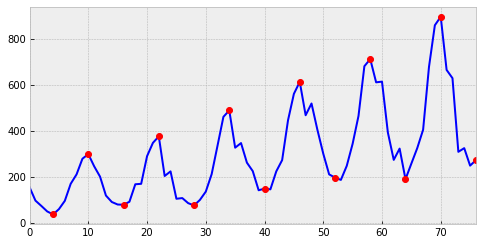

In [131]:
plot_ts_and_points(sales_of_company_x['Count'], 4, 6)

Строим модель:

In [132]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [133]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [134]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [135]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

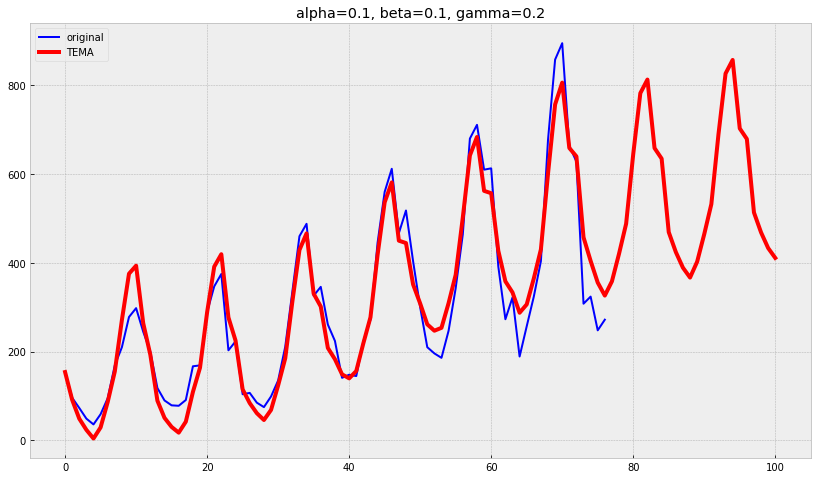

In [136]:
plot_tema(0.1, 0.1, 0.2)

# Подбор параметров

Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [137]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [138]:
series = sales_of_company_x["Count"]

In [139]:
train, test, val = series[:60], series[60:70], series[70:]

In [140]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [141]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [142]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4491.31885198594
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1951.43165911, 1452.56472024, 1560.77576321])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 18
   status: 0
  success: True
        x: array([0.12178109, 0.32826846, 0.79252248])


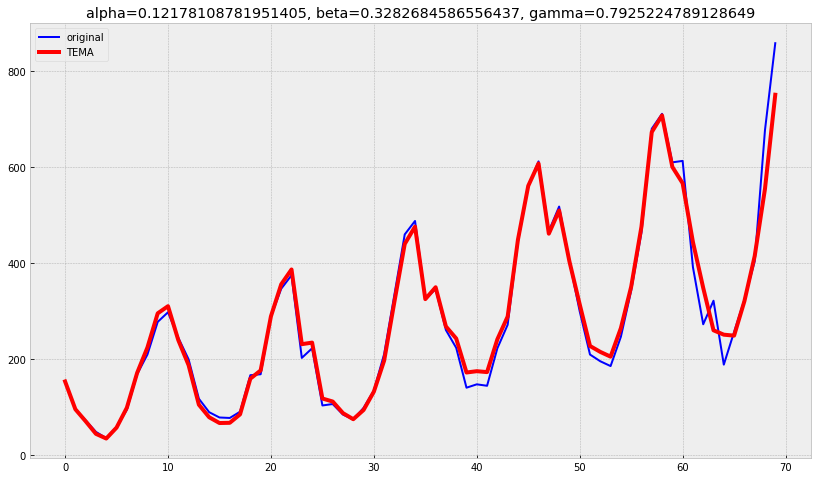

In [143]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

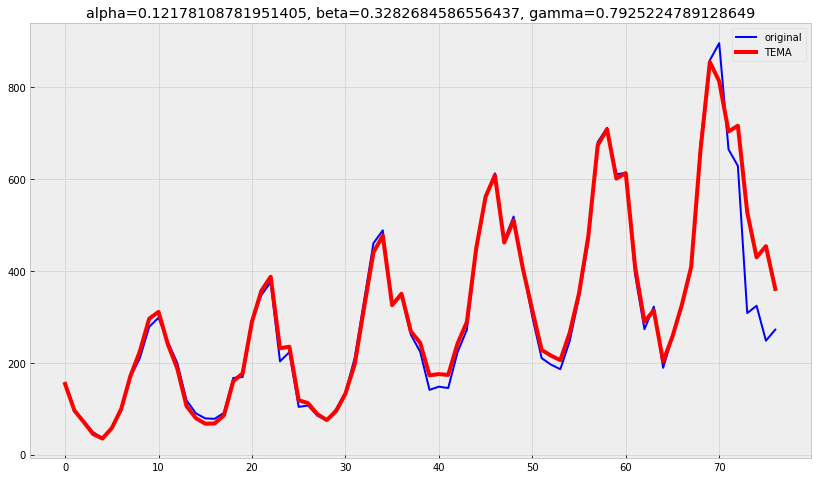

In [144]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [145]:
result = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
predictions = result[-len(test):]
mse = mean_squared_error(predictions, test)
print("Root Mean Squared Error: {}".format(np.sqrt(mse)))

Root Mean Squared Error: 67.01730263137975


# Кросс-валидация

In [146]:
train, val = series[:65], series[65:]

In [147]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [148]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [149]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7232.932670779645
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494702e-04, -1.81898940e-02, -5.53460086e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 9
   status: 0
  success: True
        x: array([0.73522291, 0.0025627 , 1.        ])


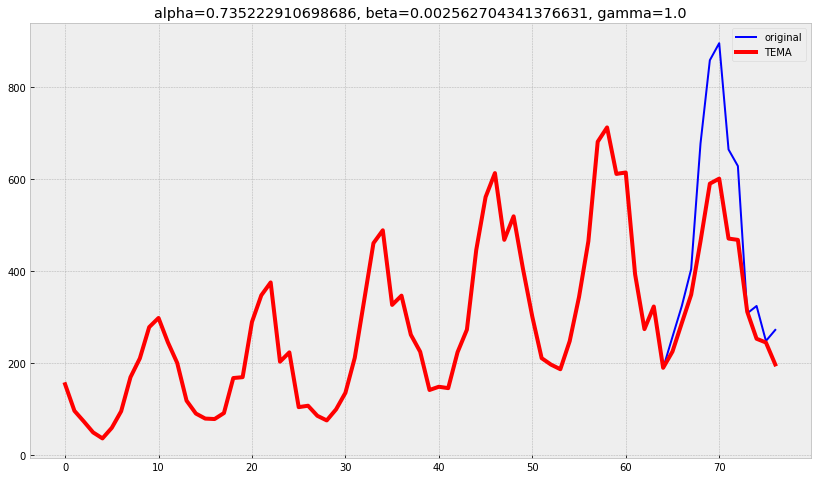

In [150]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [151]:
split = TimeSeriesSplit(n_splits=3) 
for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

In [152]:
result = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test_split))
predictions = result[-len(test_split_ts):]
mse = mean_squared_error(predictions, test_split_ts)
print("Root Mean Squared Error: {}".format(np.sqrt(mse)))

Root Mean Squared Error: 272.46363149661306


Ошибка ниже, следовательно, новые подобранные параметры с помощью кросс-валидацию делают прогнозную силу модели сильнее

#### Сделаем то же самое только теперь преобразов ряд в стационарный:

In [153]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [154]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [155]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [156]:
from scipy.stats import boxcox

In [171]:
series = sales_of_company_x["Count"]

In [172]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


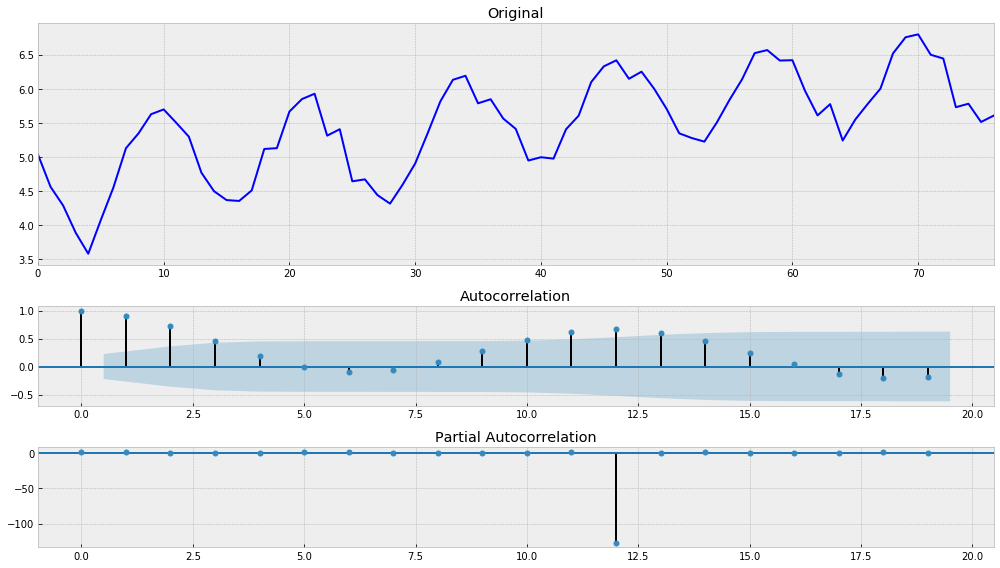

In [173]:
tsplot(series)

Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием и исключив сезонность.

In [174]:
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


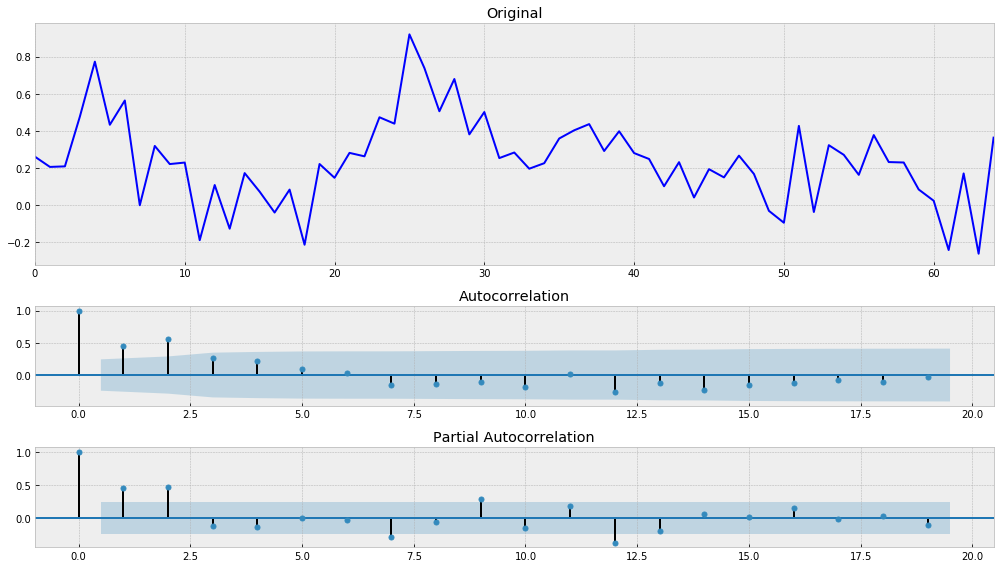

In [175]:
tsplot(series)

К сожалению, сделать ряд стационарным не получилось даже после нормализации дисперсии и дифференцируя с учетом сезонности, тем не менее попробуем построить прогноз на базе обычного скользящего среднего без подбора параметров:

In [176]:
series = pd.Series(series) 

In [180]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

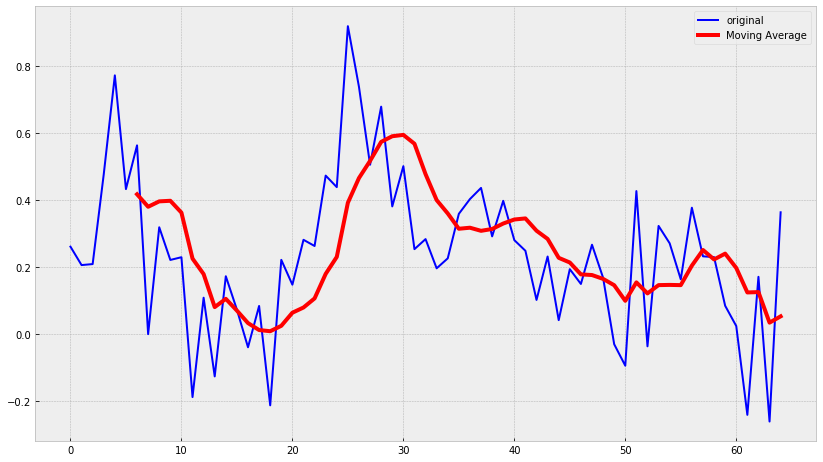

In [183]:
ser = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [177]:
train, val = series[:50], series[50:]

In [189]:
split = TimeSeriesSplit(n_splits=3) 
errors = []

for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        
        result = moving_average(series, 7)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

print("Root Mean Squared Error: {}".format(np.sqrt(np.mean(np.array(errors)))))

Root Mean Squared Error: 0.2770645132328993


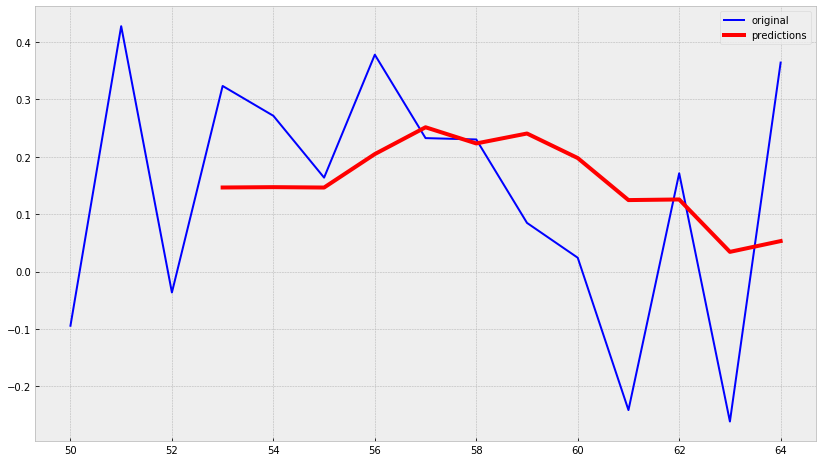

In [191]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[50:], color='blue',label='original')
    plt.plot(predictions, color='red', linewidth='4', label='predictions')
    plt.legend()